# Build an AI model to segment lung lobes

The objective is to train a Neural Network to segment lung lobes. The dataset has 50 CT scans with annotated mask. I implemented a U-net model to take as input arrays of parches with shape (128, 128, 128) and predict as output the segmented masks.**bold text**

In [5]:
!pip install SimpleITK
!pip install pynrrd
from numpy.random import randint
from __future__ import print_function
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread
import SimpleITK as sitk
import matplotlib.pyplot as plt
import glob
import numpy as np
import nrrd
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.   Import Data and Visualize images

---

- Upload zip files to drive
- Unzip files to create folders.




In [0]:
!unzip -uq "/content/drive/My Drive/Colab Notebooks/patch_train_dataset.zip" -d "/content/drive/My Drive/Colab Notebooks"
!unzip -uq "/content/drive/My Drive/Colab Notebooks/patch_train_mask_dataset.zip" -d "/content/drive/My Drive/Colab Notebooks"

The following script is based on the raw data in folders '/volume' and '/mask'.

In [0]:
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import nrrd
import os
from numpy.random import randint
from matplotlib import pyplot as plt
from data3D import get_filenames

data_path = './'

train_files, mask_files = get_filenames()

train_data_path = os.path.join(data_path, 'volume/')
mask_data_path = os.path.join(data_path, 'mask/')

train_arrays_list = []
mask_arrays_list = []  
for image in range(len(train_files)):
    img_train = sitk.ReadImage(train_data_path+train_files[image])
    out_img = sitk.GetArrayFromImage(img_train)
    train_arrays_list.append(out_img)
    
    img_mask = sitk.ReadImage(mask_data_path+mask_files[image])
    out_mask = sitk.GetArrayFromImage(img_mask)
    mask_arrays_list.append(out_mask)

img_vol = train_arrays_list[0]
mask_vol = mask_arrays_list[0]


im_vol = img_vol[60, :, :]
print('Shape of volume is '+str(im_vol.shape))

im_mask = mask_vol[60, :, :]
print('Shape of mask is '+str(im_mask.shape))

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(im_vol)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(im_mask)


ax1.set_title('CT image')
ax2.set_title('CT mask')

plt.show()



# 2.   Extract Patches of shape (128x128x128)


---



Next, I created a script to extract patches from the raw volumes to get consistent input shapes for the Neural Network.

I also normalized the data and added a 4th dimension as channel.

In [0]:
data_path = './drive/My Drive/Colab Notebooks/'

#change the paths for accessing the raw data folders
def get_filenames():
    train_data_path = os.path.join(data_path, 'patch_train_dataset/')
    mask_data_path = os.path.join(data_path, 'patch_train_mask_dataset/')
    train_dirs = sorted(os.listdir(train_data_path))
    mask_dirs = sorted(os.listdir(mask_data_path))

    return train_dirs, mask_dirs

def create_patch_dataset():
    # paths to folders with raw data
    train_data_path = os.path.join(data_path, '/raw_volume/')
    mask_data_path = os.path.join(data_path, '/raw_mask/')

    # create output folders
    patch_folder_scan = data_path+'patch_train_dataset/'
    patch_folder_mask = data_path+'patch_train_mask_dataset/'
    if not os.path.exists(patch_folder_scan):
        os.makedirs(patch_folder_scan)
    if not os.path.exists(patch_folder_mask):
        os.makedirs(patch_folder_mask)
    
    train_files, mask_files = get_filenames()

    # create list of arrays of normalized train patches (128, 128, 128, 1)
    train_arrays_list = []

    # create list of arrays of normalized mask patches (128, 128, 128, 1)   
    mask_arrays_list = []  
    patient_list = []

    for image in range(len(train_files)):

        img_mask = sitk.ReadImage(mask_data_path+mask_files[image])
        out_img = sitk.GetArrayFromImage(img_mask)
        
        img_train = sitk.ReadImage(train_data_path+train_files[image])
        out_mask = sitk.GetArrayFromImage(img_train)

        if out_img.shape[0]-1 > 128 and out_img.shape[1]-1 > 128:
            patch_origin = randint(0, (((out_img.shape[0])-1)-128))
            patch_train = out_img[patch_origin:patch_origin+128, 
                                    patch_origin:patch_origin+128,
                                    patch_origin:patch_origin+128]
            patch_train = patch_train.astype('float32')
            patch_train /= 255.  # scale masks to [0, 1]
            patch_train = np.expand_dims(patch_train, axis = 3) 
            train_arrays_list.append(patch_train)
            print('train vol: '+str(image))
            # sava patch of train and mask in numpy array.
            np.save('./patch_train_dataset/train_patch_'+str(image), patch_train)

            patch_mask = out_mask[patch_origin:patch_origin+128, 
                                     patch_origin:patch_origin+128,
                                     patch_origin:patch_origin+128]
            patch_mask = patch_mask.astype('float32')
            patch_mask /= 255.  # scale masks to [0, 1]
            patch_mask = np.expand_dims(patch_mask, axis = 3)
            mask_arrays_list.append(patch_mask)
            print('train mask: '+str(image))

            # create list of selected files and print not selected ones.
            patient_list.append(str(image))

            # sava patch of train and mask in numpy array.
            np.save('./patch_train_mask_dataset/mask_patch_'+str(image), patch_mask)

        else:
            print('Patient number '+str(image)+' has not enough slices or' 
                  'rows/columns for 128x128x128 patches') 

    print('Loading of train and mask datasets done.')
    print('Saving to .npy files done.')

    return train_arrays_list, mask_arrays_list, patient_list

Load patches into list of arrays.

In [0]:
def load_patch_dataset():
    train_files, mask_files = get_filenames()

    data_path = './drive/My Drive/Colab Notebooks/'

    # paths to folders with patches
    train_data_path = os.path.join(data_path, 'patch_train_dataset/')
    mask_data_path = os.path.join(data_path, 'patch_train_mask_dataset/')

    train_arrays_list = []
    for image in range(len(train_files)):
        out = np.load(train_data_path+train_files[image])
        train_arrays_list.append(out)
    mask_arrays_list = []
    for image in range(len(mask_files)):
        out = np.load(mask_data_path+mask_files[image])
        mask_arrays_list.append(out)

    return train_arrays_list, mask_arrays_list

In [15]:
train_files, mask_files = get_filenames()
print(train_files)
print(mask_files)

['train_patch_0.npy', 'train_patch_1.npy', 'train_patch_11.npy', 'train_patch_13.npy', 'train_patch_15.npy', 'train_patch_16.npy', 'train_patch_17.npy', 'train_patch_18.npy', 'train_patch_19.npy', 'train_patch_2.npy', 'train_patch_20.npy', 'train_patch_21.npy', 'train_patch_23.npy', 'train_patch_24.npy', 'train_patch_25.npy', 'train_patch_26.npy', 'train_patch_27.npy', 'train_patch_28.npy', 'train_patch_29.npy', 'train_patch_3.npy', 'train_patch_30.npy', 'train_patch_31.npy', 'train_patch_32.npy', 'train_patch_33.npy', 'train_patch_34.npy', 'train_patch_35.npy', 'train_patch_36.npy', 'train_patch_37.npy', 'train_patch_38.npy', 'train_patch_39.npy', 'train_patch_4.npy', 'train_patch_41.npy', 'train_patch_42.npy', 'train_patch_43.npy', 'train_patch_44.npy', 'train_patch_45.npy', 'train_patch_46.npy', 'train_patch_49.npy', 'train_patch_6.npy', 'train_patch_7.npy', 'train_patch_8.npy', 'train_patch_9.npy']
['mask_patch_0.npy', 'mask_patch_1.npy', 'mask_patch_11.npy', 'mask_patch_13.npy', '

 

# 3.   Visualize 2D images and masks


---





Shape of volume is (128, 128)
Shape of mask is (128, 128)


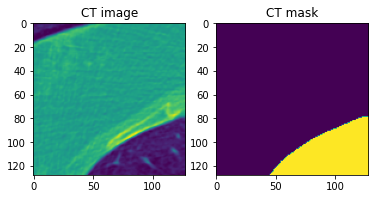

In [23]:
from matplotlib import pyplot as plt

train_arrays_list, mask_arrays_list = load_patch_dataset()
img_vol = train_arrays_list[27]
mask_vol = mask_arrays_list[27]

img_vol_sq = np.squeeze(img_vol,axis=3)
img_mask_sq = np.squeeze(mask_vol,axis=3)

im_vol = img_vol_sq[60, :, :]
print('Shape of volume is '+str(im_vol.shape))
im_mask = img_mask_sq[60, :, :]
print('Shape of mask is '+str(im_mask.shape))

fig = plt.figure()

ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(im_vol)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(im_mask)


ax1.set_title('CT image')
ax2.set_title('CT mask')

plt.show()

# 4. Visualize 3D Volumes

Interactive volume viewer (succesful in Jupyter Notebook)

In [24]:
%matplotlib notebook

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)
                

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])


train_arrays_list , mask_arrays_list = load_patch_dataset()

img = np.squeeze(train_arrays_list[34], axis=3)

multi_slice_viewer(img)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5. 3D-Unet Segmentation of Lungs

In [0]:
import tensorflow.python.keras.models as models
from skimage.transform import resize
#np.random.seed(256)
import tensorflow as tf
#tf.set_random_seed(256)
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from tensorflow.python.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.regularizers import l2

In [0]:
project_name = '3D-Unet Segmentation of Lungs'
img_rows = 128
img_cols = 128
img_depth = 128
K.set_image_data_format('channels_last')

def get_unet():
    inputs = Input(shape=(img_depth, img_rows, img_cols, 1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
                          #epsilon=1e-07, amsgrad=False, name='Adam')

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# 6. Choose between train and test sets or cross validation method.

In [0]:
def split_data():
  train_arrays_list, mask_arrays_list = load_patch_dataset()

  # We use 90% of the data for training/validation and 10% for testing.
  alpha = np.int16(np.floor(len(train_arrays_list)* 0.7))
  end = len(train_arrays_list)

  train_img = np.array(train_arrays_list[0:alpha])
  train_mask = np.array(mask_arrays_list[0:alpha])

  test_img = np.array(train_arrays_list[alpha:end])
  test_mask = np.array(mask_arrays_list[alpha:end])

  return train_img, train_mask, test_img, test_mask

In [0]:
def train_cross_validation():

    from sklearn.model_selection import KFold

    # Model configuration
    num_folds = 10

    # Loading and preprocessing train data
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    train_dirs, mask_dirs = get_filenames()

    train_arrays_list, mask_arrays_list = load_patch_dataset()
  
    train_img, train_mask, test_img, test_mask = split_data()

    num_folds = 10

    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5')
                                       , monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    # Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []

    # Merge inputs and targets
    inputs = np.concatenate((train_img, test_img), axis=0)
    targets = np.concatenate((train_mask, test_mask), axis=0)

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    # for loop
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

      # Generate a print
      print('------------------------------------------------------------------------')
      print(f'Training for fold {fold_no} ...')
      
      
      print('-'*30)
      print('Creating and compiling model...')
      print('-'*30)
            
      model = get_unet()
      
      weight_dir = 'weights'
      if not os.path.exists(weight_dir):
          os.mkdir(weight_dir)
      model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5')
                                        , monitor='val_loss', save_best_only=True)

      log_dir = 'logs'
      if not os.path.exists(log_dir):
          os.mkdir(log_dir)
      csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

      print('-'*30)
      print('Fitting model...')
      print('-'*30)

      # fit data to model
      history = model.fit(inputs[train], targets[train], 
                batch_size=1, 
                epochs=40, 
                verbose=1, 
                shuffle=True, 
                validation_split=0.10, 
                callbacks=[model_checkpoint, csv_logger])

      # Generate generalization metrics
      scores = model.evaluate(inputs[test], targets[test], verbose=0)

      print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])

      # Increase fold number
      fold_no = fold_no + 1


    print('-'*30)
    print('Training finished')
    print('-'*30)


    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')



# 7. Train the model with simple train/test split.

In [39]:
print('-'*30)
print('Loading and preprocessing train data...')
print('-'*30)

train_dirs, mask_dirs = get_filenames()

# comment the next line if uploaded the patches in drive.
train_arrays_list, mask_arrays_list = load_patch_dataset()

# uncomment the next line if uploaded the raw data in Drive.
# train_arrays_list, mask_arrays_list, patient_list = create_patch_dataset()

print('-'*30)
print('Creating and compiling model...')
print('-'*30)

model = get_unet()
weight_dir = 'weights'
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5')
                                    , monitor='val_loss', save_best_only=True)

log_dir = 'logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

print('-'*30)
print('Fitting model...')
print('-'*30)

# split data in train and test sets.
train_img, train_mask, test_img, test_mask = split_data()

# fit data to model
history = model.fit(train_img, train_mask, 
          batch_size=1, 
          epochs=50, 
          verbose=1, 
          shuffle=True, 
          validation_split=0.10, 
          callbacks=[model_checkpoint, csv_logger])



print('-'*30)
print('Training finished')
print('-'*30)





------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d_76 (Conv3D)              (None, 128, 128, 128 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv3d_77 (Conv3D)              (None, 128, 128, 128 27680       conv3d_76[0][0]                  
______________________________________________________________________________________________

# 7.1 Plot the training and validation loss

In [42]:
# plot results
EPOCHS = 50
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 8. Evaluate the model on Test set

In [0]:
# Generate generalization metrics
score = model.evaluate(test_img, test_mask, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# 9. Cross validation function
 Uses a more valid methodology for evaluating the performance of the trained model.

In [0]:
train_cross_validation()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# 10. Pedictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

In [0]:
def show_prediction():
  train_img, train_mask, test_img, test_mask = split_data()

  image = test_img[0]
  pred_mask = model.predict(image)

  x_img = train_img[0]
  m_img = train_mask[0]
  y_img = pred_mask

  fig = plt.figure()

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.imshow(x_img)

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.imshow(m_img)

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.imshow(y_img)

  ax1.set_title('CT image')
  ax2.set_title('CT mask')
  ax3.set_title('CT prediction')

  plt.show()


# Conclusion:

 I implemented a Unet model to segment lung lobes with cross validation and patches extraction.


 I will continue the evaluation of the project by comparing the prediction to the original scans and it's annoted mask.

 I did'nt have time to fine-tune the hyperparameters to improve the NN's performance. But could definitively get better results by:
 - varying the number of epochs.
 - increasing the number of patches with data augmentation (rotate, flip, shear, ..)
 - playing around with different optimizers and changing parameters.
 - Batch size
 - Learning rate
 - Unet architecture


 As a result, this project was succesful but requires more time for plotting final results and changing parameters.